In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os

In [0]:
os.chdir('gdrive/My Drive/data')

In [0]:
import tensorflow as tf
import numpy as np
from utils import load_data, train_dev_test, make_map_from_nested, word_vectors, trigram_vectors, all_vectors
from sklearn.preprocessing import LabelEncoder

In [0]:
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, Flatten, Concatenate, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
seed = 42
database, top_tokens = load_data('./')

In [0]:
classes = list(set(database['class']))
classes.sort()

In [0]:
train, dev, test = train_dev_test(database, seed)

In [0]:
class_map = {classes[idx]:idx for idx in range(len(classes))}  # class mapping to integers
word_map = make_map_from_nested(top_tokens['top_words'].values())
trigram_map = make_map_from_nested(top_tokens['top_trigrams'].values())

In [0]:
y_train_ints = np.array([class_map[label] for label in train['class']])
y_dev_ints = np.array([class_map[label] for label in dev['class']])
y_test_ints = np.array([class_map[label] for label in test['class']])

In [0]:
y_train = to_categorical(y_train_ints, 10)
y_dev = to_categorical(y_dev_ints, 10)
y_test = to_categorical(y_test_ints, 10)

In [0]:
results = set()
for sen in train['text']:
    results.update(sen.split())
all_map = {w:i for i, w in enumerate(list(results))}

In [0]:
X_train_words = word_vectors(train['text'], word_map)
X_train_trigrams = trigram_vectors(train['text'], trigram_map)
X_train_all = all_vectors(train['text'], all_map)
X_dev_words = word_vectors(dev['text'], word_map)
X_dev_trigrams = trigram_vectors(dev['text'], trigram_map)
X_dev_all = all_vectors(dev['text'], all_map)
X_test_words = word_vectors(test['text'], word_map)
X_test_trigrams = trigram_vectors(test['text'], trigram_map)
X_test_all = all_vectors(test['text'], all_map)

In [0]:
max_word_len = max(max([len(s) for s in X_train_words]),
                   max([len(s) for s in X_dev_words]),
                   max([len(s) for s in X_test_words]))
max_tri_len = max(max([len(s) for s in X_train_trigrams]),
                  max([len(s) for s in X_dev_trigrams]),
                  max([len(s) for s in X_test_trigrams]))
max_all_len = 450

In [0]:
X_train_w = pad_sequences(X_train_words, max_word_len, padding='post')
X_train_t = pad_sequences(X_train_trigrams, max_tri_len, padding='post')
X_train_a = pad_sequences(X_train_all, max_all_len, padding='post')
X_dev_w = pad_sequences(X_dev_words, max_word_len, padding='post')
X_dev_t = pad_sequences(X_dev_trigrams, max_tri_len, padding='post')
X_dev_a = pad_sequences(X_dev_all, max_all_len, padding='post')
X_test_w = pad_sequences(X_test_words, max_word_len, padding='post')
X_test_t = pad_sequences(X_test_trigrams, max_tri_len, padding='post')
X_test_a = pad_sequences(X_test_all, max_all_len, padding='post')

X_train_w = np.expand_dims(X_train_t, axis=2)
X_dev_w = np.expand_dims(X_dev_t, axis=2)
X_test_w = np.expand_dims(X_test_t, axis=2)
X_train_t = np.expand_dims(X_train_t, axis=2)
X_dev_t = np.expand_dims(X_dev_t, axis=2)
X_test_t = np.expand_dims(X_test_t, axis=2)

In [0]:
def build_model(word_vocab_size,
                word_embedding_size,
                word_input_length,
                trigram_vocab_size,
                trigram_embedding_size,
                trigram_input_length,
                all_vocab_size,
                all_embedding_size,
                all_input_length,
                dropout_rate,
                num_classes):
    word_input = Input(shape=(word_input_length,))
    trigram_input = Input(shape=(trigram_input_length,))
    all_input = Input(shape=(all_input_length,))

    word_embedding = Embedding(input_dim=word_vocab_size,
                               output_dim=word_embedding_size,
                               input_length=word_input_length,
                               trainable=True)(word_input)
    x1 = Conv1D(26, 2, activation='relu')(word_embedding)
    x1 = MaxPooling1D(2)(x1)
    x1 = Flatten()(x1)
    x1 = BatchNormalization(trainable=True)(x1)
    x1 = Model(inputs=word_input, outputs=x1)

    trigram_embedding = Embedding(input_dim=trigram_vocab_size,
                               output_dim=trigram_embedding_size,
                               input_length=trigram_input_length,
                               trainable=True)(trigram_input)
    x2 = Conv1D(26, 2, activation='relu')(trigram_embedding)
    x2 = MaxPooling1D(2)(x2)
    x2 = Flatten()(x2)
    x2 = BatchNormalization(trainable=True)(x2)
    x2 = Model(inputs=trigram_input, outputs=x2)

    all_embedding = Embedding(input_dim=all_vocab_size,
                              output_dim=all_embedding_size,
                              input_length=all_input_length,
                              trainable=True)(all_input)
    x3 = Conv1D(52, 2, activation='relu')(all_embedding)
    x3 = MaxPooling1D(3)(x3)
    x3 = Flatten()(x3)
    x3 = BatchNormalization(trainable=True)(x3)
    x3 = Model(inputs=all_input, outputs=x3)

    combined = Concatenate()([x1.output, x2.output, x3.output])
    z = Dense(512, activation='relu')(combined)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(256, activation='relu')(z)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(num_classes, activation='softmax')(z)

    model = Model(inputs=[x1.input, x2.input, x3.input], outputs=z)

    return model

In [0]:
word_vocab_size = len(word_map) + 1  # Adding 1 because of reserved 0 index
word_embedding_size = 100
trigram_vocab_size = len(trigram_map) + 1
trigram_embedding_size = 50
all_vocab_size = len(all_map) + 1
all_embedding_size = 150
dropout_rate = 0.5
batch_size = 512
epochs = 100
num_classes = 10

In [0]:
model = build_model(word_vocab_size, word_embedding_size, max_word_len,
                    trigram_vocab_size, trigram_embedding_size, max_tri_len,
                    all_vocab_size, all_embedding_size, max_all_len,
                    dropout_rate, num_classes)

In [0]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 519)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 450)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 360, 100)     168900      input_1[0][0]                    
____________________________________________________________________________________________

In [23]:
history=model.fit([X_train_w, X_train_t, X_train_a], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [mc, earlystop],
          verbose=1,
          validation_data=([X_dev_w, X_dev_t, X_dev_a], y_dev))

Epoch 1/100
186/186 [==============================] - 66s 355ms/step - loss: 0.7626 - accuracy: 0.7840 - val_loss: 1.1530 - val_accuracy: 0.6034
Epoch 2/100
186/186 [==============================] - 62s 334ms/step - loss: 0.1107 - accuracy: 0.9682 - val_loss: 0.4028 - val_accuracy: 0.8745
Epoch 3/100
186/186 [==============================] - 59s 317ms/step - loss: 0.0270 - accuracy: 0.9928 - val_loss: 0.4676 - val_accuracy: 0.8605
Epoch 4/100
186/186 [==============================] - 58s 313ms/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.9287 - val_accuracy: 0.7509


In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

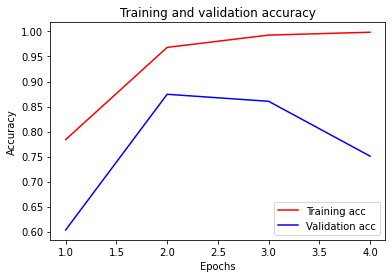

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

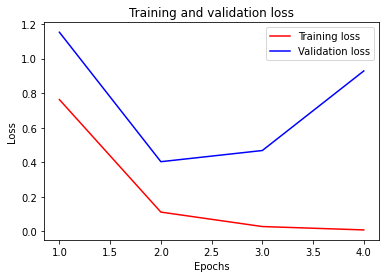

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
model.load_weights('best_model.h5')

In [28]:
score = model.evaluate([X_test_w, X_test_t, X_test_a], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3851517140865326
Test accuracy: 0.8807495832443237


In [29]:
score

[0.3851517140865326, 0.8807495832443237]

In [0]:
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
y_preds = model.predict([X_test_w, X_test_t, X_test_a]).argmax(axis=1)

In [42]:
confusion_matrix(y_test_ints, y_preds)

array([[ 138,    0,    0,    1,    0,    2,   30,    0,    0,    0],
       [  10,   25,    3,    5,    0,    8,   23,    0,    1,    0],
       [  10,    0,  446,    3,    0,   11,   85,    0,    0,    0],
       [   8,    0,    2,  230,    0,   15,   70,    0,    0,    0],
       [   4,    0,    0,    1,  284,   30,   23,    0,    1,    1],
       [   0,    0,    0,    0,    0, 1325,   25,    0,    0,    0],
       [   5,    0,    0,    0,    0,    7, 1805,    0,    0,    0],
       [   5,    0,    5,    0,    0,   50,   96,  344,    0,    1],
       [   0,    0,    0,    0,    1,    3,   29,    0,   22,    0],
       [   4,    1,    0,    0,    0,   33,   16,    0,    2,   34]])

In [43]:
print(classification_report(y_test_ints, y_preds))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       171
           1       0.96      0.33      0.50        75
           2       0.98      0.80      0.88       555
           3       0.96      0.71      0.81       325
           4       1.00      0.83      0.90       344
           5       0.89      0.98      0.94      1350
           6       0.82      0.99      0.90      1817
           7       1.00      0.69      0.81       501
           8       0.85      0.40      0.54        55
           9       0.94      0.38      0.54        90

    accuracy                           0.88      5283
   macro avg       0.91      0.69      0.76      5283
weighted avg       0.89      0.88      0.87      5283

